In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import string
from PIL import Image
from keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from random import shuffle
from keras.layers import LSTM, Embedding, Dense, Dropout, Input
from keras.layers.merge import add

In [2]:
DATA_DIR = './data/image_captioning/'

In [3]:
def fix_text(text):
    table = str.maketrans('', '', string.punctuation)
    text = text.split()
    text = [word.lower() for word in text]
    text = [w.translate(table) for w in text]
    text = [word for word in text if len(word) > 1]
    text = [word for word in text if word.isalpha()]
    text = 'startseq ' + ' '.join(text) + ' endseq'
    return text

def load_image(filename):
    path = DATA_DIR + 'images/'
    img = Image.open(path + filename)
    img = img.resize((224, 224))
    img_arr = np.array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_input(img_arr)
    return img_arr

def extract_features(feature_extractor_model, filename):
    img_arr = load_image(filename) 
    feature_vector = feature_extractor_model.predict(img_arr) 
    feature_vector = np.reshape(feature_vector, (-1, ))
    return feature_vector

In [4]:
captions_dataframe = pd.read_csv(DATA_DIR + 'results.csv', delimiter='|').drop('comment_number', axis=1)

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,"Two young , White males are outside near many ..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


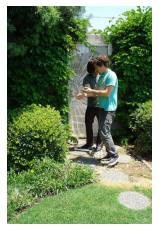

In [5]:
captions_dataframe.head(5)
filename = captions_dataframe['image_name'].iloc[0]
image = Image.open(DATA_DIR + 'images/' + filename)
plt.imshow(image)
plt.axis('off')
captions_dataframe.head(5)

In [6]:
captions_dataframe['comment'] = captions_dataframe['comment'].apply(fix_text)
captions_dataframe['image_name'] = captions_dataframe['image_name'].apply(lambda x: x.split('.')[0])

In [7]:
max_caption_length = captions_dataframe['comment'].apply(lambda x: len(x.split())).max()

word_count_threshold = 10
word_counts = {}

for sentence in captions_dataframe['comment']:
    for w in sentence.split():
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
vocab_size = len(vocab) + 1

print('Preprocessed words {} -> {}'.format(len(word_counts), len(vocab)))

Preprocessed words 19737 -> 5437


In [8]:
word_to_index = {}
index_to_word = []

for index, word in enumerate(vocab):
    word_to_index[word] = index
    index_to_word.append(word)

In [9]:
captions_list_by_name_dict = {}

for _, (name, caption) in captions_dataframe.iterrows():
    if name in captions_list_by_name_dict: captions_list_by_name_dict[name].append(caption)
    else: captions_list_by_name_dict[name] = [caption]

grouped_captions = []

for key, value in captions_list_by_name_dict.items():
    grouped_captions.append([key, value])

In [10]:
def data_generator(feature_extractor_model, grouped_captions):
    image_features, in_sequence, out_sequennce = [], [], []
    while True:
        shuffle(grouped_captions)

        for name, captions in grouped_captions:
            im_fea = extract_features(feature_extractor_model, name + '.jpg')
        
            for caption in captions:
                encoded_sequence = [word_to_index[word] for word in caption.split() if word in word_to_index]
                for i in range(1, len(encoded_sequence)):
                    in_seq, out_seq = encoded_sequence[:i], encoded_sequence[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    image_features.append(im_fea)
                    in_sequence.append(in_seq)
                    out_sequennce.append(out_seq)
                
            
            yield [[np.array(image_features), np.array(in_sequence)], np.array(out_sequennce)]
            image_features, in_sequence, out_sequennce = [], [], []

<b>Feature Extractor Model</b>

In [11]:
feature_extractor_model = VGG19(weights='imagenet')
feature_extractor_model = Model(feature_extractor_model.input, feature_extractor_model.layers[-2].output)

In [12]:
shuffle(grouped_captions)
train_val_grouped_captions, test_grouped_captions = train_test_split(grouped_captions, test_size=0.2, random_state=42)
train_grouped_captions, val_grouped_captions = train_test_split(train_val_grouped_captions, test_size=0.2, random_state=42)

In [13]:
train_generator = data_generator(feature_extractor_model, train_grouped_captions)
val_generator = data_generator(feature_extractor_model, val_grouped_captions)
test_generator = data_generator(feature_extractor_model, test_grouped_captions)

In [14]:
for item in train_generator:
    print(item[0][0].shape, item[0][1].shape, item[1].shape)
    break

2022-06-16 16:45:09.852934: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(48, 4096) (48, 74) (48, 5438)


<b><a href="https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/">GloVe</a></b>

In [15]:
glove_dir = DATA_DIR + 'glove.6B.200d.txt'
embeddings_index = {}

with open(glove_dir) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefs

embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

<b>Caption Generator Model</b>

In [19]:
feature_input = Input(shape=(4096,))
feature_layer1 = Dropout(0.5)(feature_input)
feature_layer2 = Dense(256, activation='relu')(feature_layer1)
caption_input = Input(shape=(max_caption_length, ))
caption_layer1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(caption_input)
caption_layer2 = Dropout(0.5)(caption_layer1)
caption_layer3 = LSTM(256)(caption_layer2)
decoder1 = add([feature_layer2, caption_layer3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_generation_model = Model(inputs=[feature_input, caption_input], outputs=outputs)

In [17]:
caption_generation_model.layers[2].set_weights([embedding_matrix])
caption_generation_model.layers[2].trainable = False

caption_generation_model.compile(loss='categorical_crossentropy', optimizer='adam')
epochs = 20
batch_size = 3
steps = len(grouped_captions) // batch_size

In [ ]:
history = caption_generation_model.fit(
    train_generator, 
    epochs=epochs, 
    steps_per_epoch=steps, 
    validation_data=val_generator, 
    validation_steps=steps,
    batch_size=batch_size,
    verbose=1
)
caption_generation_model.save(DATA_DIR + 'saved_model/model_' + str(20) + '.h5')

In [ ]:
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.figure() 
 
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('First 20 Epochs')

In [ ]:
# caption_generation_model.optimizer.lr = 0.0001
# epochs = 10
# batch_size = 6
# steps = len(grouped_captions) // batch_size

In [ ]:
# history1 = caption_generation_model.fit(
#     train_generator, 
#     epochs=epochs, 
#     steps_per_epoch=steps, 
#     validation_data=val_generator, 
#     validation_steps=steps,
#     batch_size=batch_size,
#     verbose=1
# )
# caption_generation_model.save(DATA_DIR + 'saved_model/model_' + str(30) + '.h5')

In [ ]:
# training_loss = history1.history['loss']
# epoch_count = range(1, len(training_loss) + 1)
# plt.figure()  

# plt.plot(epoch_count, training_loss, 'r--')
# plt.legend(['Training Loss'])
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Last 10 Epochs')

In [20]:
def generate_caption(image_features):
    in_text = 'startseq'
    for _ in range(max_caption_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        yhat = caption_generation_model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final.capitalize() + '.'

Rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock rock.


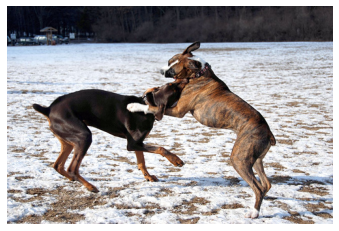

Barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn barn.


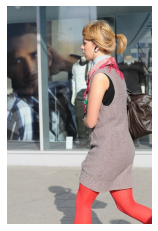

Disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk disk.


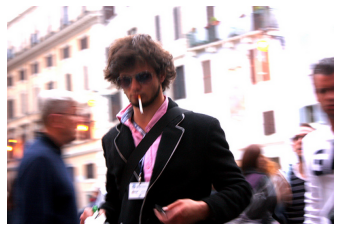

In [21]:
for name, caption_list in test_grouped_captions[:3]:
    image_features = extract_features(feature_extractor_model, name + '.jpg').reshape(1, 4096)
    caption = generate_caption(image_features)
    with Image.open(DATA_DIR + 'images/' + name + '.jpg') as img:
        img = np.array(img)
        img = img / 255.0
        print(caption)
        plt.imshow(img)
        plt.axis('off')
        plt.show()